# Analyzing experiment from 5/31/2016

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret.visualizations as pyviz
import pyret.filtertools as ft
import pyret.spiketools as st
import pyret.stimulustools as stimtools
import jetpack
from experiments.iotools import read_channel # from niru-analysis github
from experiments.photodiode import find_peaks, find_start_times
# import binary     # in igor >> recording
import pdb
import string
# from jetpack.signals import peakdet
from scipy.signal import find_peaks_cwt
from os.path import expanduser

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## experiment directory

In [2]:
data_dir = '/Users/lmcintosh/experiments/data/16-05-31/'
stim_dir = '/Users/lmcintosh/experiments/data/16-05-31/stimulus/'
stimulus_filename = '16-05-31-stimulus.h5'

## load spikes

In [46]:
fs = sorted(os.listdir(data_dir))
fs = [f for f in fs if f.endswith(".txt")]

cells = []
for f in fs:
    text_file = open(data_dir + f, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) for spike in spikes if (not (not spike)) and float(spike) > 0])
    
    text_file.close()

In [47]:
len(cells)

28

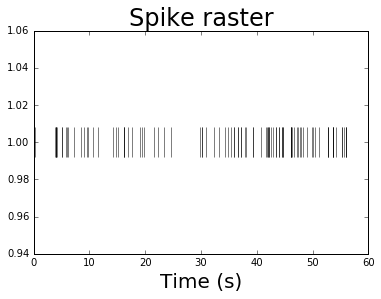

In [48]:
fig = pyviz.raster(cells[0][:100], np.ones((len(cells[0][:100]),)), marker_string='|', color='k', markersize=30)

## load stimulus

In [49]:
f = h5py.File(stim_dir + stimulus_filename)
print(len(list(f)))
list(f)

128


[u'expt1',
 u'expt10',
 u'expt100',
 u'expt101',
 u'expt102',
 u'expt103',
 u'expt104',
 u'expt105',
 u'expt106',
 u'expt107',
 u'expt108',
 u'expt109',
 u'expt11',
 u'expt110',
 u'expt111',
 u'expt112',
 u'expt113',
 u'expt114',
 u'expt115',
 u'expt116',
 u'expt117',
 u'expt118',
 u'expt119',
 u'expt12',
 u'expt120',
 u'expt121',
 u'expt122',
 u'expt123',
 u'expt124',
 u'expt125',
 u'expt126',
 u'expt127',
 u'expt128',
 u'expt13',
 u'expt14',
 u'expt15',
 u'expt16',
 u'expt17',
 u'expt18',
 u'expt19',
 u'expt2',
 u'expt20',
 u'expt21',
 u'expt22',
 u'expt23',
 u'expt24',
 u'expt25',
 u'expt26',
 u'expt27',
 u'expt28',
 u'expt29',
 u'expt3',
 u'expt30',
 u'expt31',
 u'expt32',
 u'expt33',
 u'expt34',
 u'expt35',
 u'expt36',
 u'expt37',
 u'expt38',
 u'expt39',
 u'expt4',
 u'expt40',
 u'expt41',
 u'expt42',
 u'expt43',
 u'expt44',
 u'expt45',
 u'expt46',
 u'expt47',
 u'expt48',
 u'expt49',
 u'expt5',
 u'expt50',
 u'expt51',
 u'expt52',
 u'expt53',
 u'expt54',
 u'expt55',
 u'expt56',
 u'e

In [50]:
list(f['expt1'])

[u'stim', u'timestamps']

In [51]:
(f['expt1/stim'].shape, f['expt1/timestamps'].shape)

((7503, 50, 50), (7503,))

## find peaks in photodiode to align each experiment

#### load photodiode

In [52]:
raw_data = h5py.File(data_dir + '16-05-31.h5')
pd = read_channel(raw_data, channel=119)

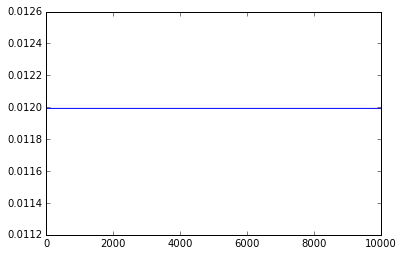

In [53]:
plt.plot(pd[:10000])

In [54]:
uniques = np.unique(pd)
uniques

array([ -8.33833165e+01,   1.19928067e-02])

In [55]:
time = np.linspace(0, len(pd)/20000., len(pd))
timestamps = [time[i] for i,p in enumerate(pd) if p == uniques[0]]

In [56]:
len(timestamps)

25983

In [57]:
estimated_peaks = 20000./30.
estimated_peaks

666.6666666666666

In [58]:
len([t for t in timestamps if t == timestamps[0]])

1

In [59]:
timestamps[:10]

[13.373300074016495,
 13.373350074016772,
 13.373400074017047,
 13.373450074017324,
 13.373500074017601,
 13.373550074017878,
 13.373600074018155,
 13.373650074018432,
 13.373700074018707,
 13.373750074018984]

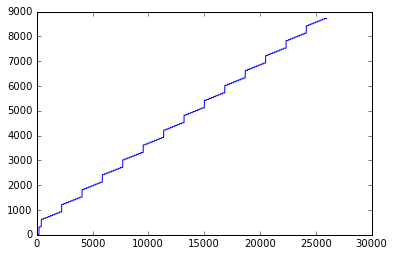

In [60]:
plt.plot(timestamps)

#### find peaks

In [61]:
peaks = [t for i,t in enumerate(timestamps[1:]) if t > (timestamps[i]+5.0)]

In [62]:
peaks.insert(0, timestamps[0])

In [63]:
len(peaks)

128

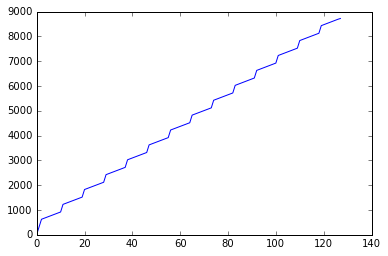

In [64]:
plt.plot(peaks)

In [65]:
peaks[:10]

[13.373300074016495,
 320.06175177142882,
 626.59020346795558,
 663.29685367111392,
 700.1367038750094,
 736.77670407779897,
 773.52335428117863,
 810.12340448374698,
 846.75000468646226,
 883.40335488932567]

#### Go from maxtab_start_indices to start times in seconds

In [66]:
from jetpack.timepiece import hrtime

In [67]:
f['expt1/timestamps'][-1]

300.0

In [68]:
start_times = peaks

# Align spikes with each experiment

In [69]:
expt_spikes = []
for expt_id, start in enumerate(start_times):
    expt_spikes.append([])
    expt_name = 'expt%d' %(expt_id+1)
    stop = f[expt_name + '/timestamps'][-1] # last timestamp, in seconds
    for c in cells:
        expt_spikes[-1].append([sp-start for sp in c if sp >= start and sp <= start+stop])

In [70]:
def spikes_to_array(spikes):
    '''
    Converts a list of spike times to an array with labels for easy
    pyret.visualizations.raster() use.
    
    INPUT:
        spikes    list of list of spike times
    '''
    collapsed_spikes = []
    collapsed_labels = []
    nlists = len(spikes)
    for idl, l in enumerate(spikes):
        labels = idl * np.ones((len(l),))
        collapsed_spikes.extend(l)
        collapsed_labels.extend(labels)
        
    return np.array(collapsed_spikes), np.array(collapsed_labels)
    

In [71]:
all_spikes, all_labels = spikes_to_array(expt_spikes[1])

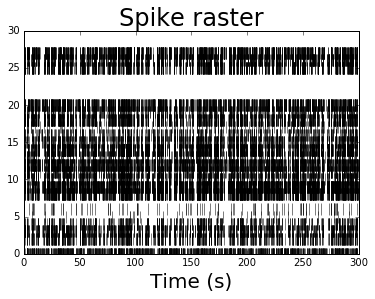

In [72]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=12)

## Look at first 8 repeats

In [73]:
c = 2
repeat_spikes = [e[c] for e in expt_spikes[2:10]]
all_spikes, all_labels = spikes_to_array(repeat_spikes)

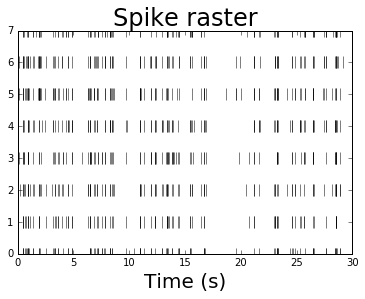

In [74]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=12)

In [75]:
c = 2
repeat_spikes = [e[c] for e in expt_spikes[11:19]]
all_spikes, all_labels = spikes_to_array(repeat_spikes)

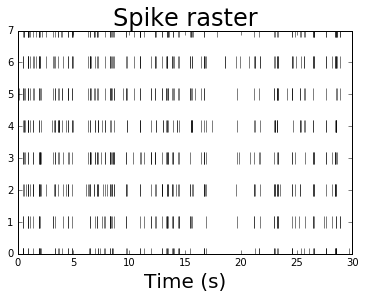

In [76]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=12)

In [77]:
len(pd)/20000.

9034.0

In [78]:
9034./3600

2.5094444444444446

# experiment structure

In [79]:
stimulus_seq = []
stimulus_seq.append('whitenoise')
# 14 single trials of 5 min each (70 min total)
for block in range(14):
    stimulus_seq.append('naturalscene_single')
    # 14 * 8 = 112 repeats
    for repeat in range(8):
        stimulus_seq.append('naturalscene_repeat')
stimulus_seq.append('whitenoise')

In [80]:
len(stimulus_seq)

128

In [81]:
len(expt_spikes)

128

In [82]:
f['expt1/stim'].shape

(7503, 50, 50)

# Check out the STAs for the 14 cells

In [83]:
from scipy.stats import zscore

In [84]:
# cell_idx = 0
# first_trial = 7
# num_diff_trials = 8
# total_trials = 24

with h5py.File(stim_dir + stimulus_filename) as f:

    stas = []
    filter_length = 40

    # whitenoise_expts = range(0,24,8)
    whitenoise_expts = [0]
    # whitenoise_expts = [0, 1, 16, 17]
    # whitenoise_expts = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 22, 23]
    for c in range(len(cells)):
        partial_sta = np.zeros((filter_length, 50, 50))
        for expt_id in whitenoise_expts:
            expt_name = 'expt%d' %(expt_id+1)
#             time = np.array(f[expt_name + '/timestamps'])
#             time = np.arange(0, 300, 1/25.00940617)
#             time = np.linspace(0,300, int(300*25.00940617))
            stimulus = zscore(f[expt_name + '/stim'])
            time = np.arange(0, stimulus.shape[0])/25.00940617
            sta = np.zeros((filter_length, 50, 50))
#             stimulus_upsample, time_upsample = stimtools.upsample_stim(stimulus, 4, time)
    #         sta, tax = ft.getsta(time_upsample, stimulus_upsample, expt_spikes[expt_id][c], filter_length)
            sta, tax = ft.getsta(time, stimulus, expt_spikes[expt_id][c], filter_length)
#             for spk in expt_spikes[expt_id][c]:
#                 ind = np.argmin(abs(spk - time))
#                 if ind > filter_length/2:
#                     if ind < len(time) - filter_length/2:
#                         sta += stimulus[ind-filter_length/2:ind+filter_length/2]

#             partial_sta += sta #/float(len(expt_spikes[expt_id][c]))
#         partial_sta /= float(len(whitenoise_expts))
        stas.append(sta)

In [85]:
whitenoise_expt = 0
with h5py.File(stim_dir + stimulus_filename) as f:

    stas = []
    filter_length = 40
    for c in range(len(cells)):
        expt_name = 'expt%d' %(whitenoise_expt+1)
        stimulus = zscore(f[expt_name + '/stim'])
        time = np.arange(0, stimulus.shape[0])/25.00940617
        stimulus_upsample, time_upsample = stimtools.upsample_stim(stimulus, 4, time)
        sta, tax = ft.getsta(time_upsample, stimulus_upsample, expt_spikes[expt_id][c], filter_length)
#         sta, tax = ft.getsta(time, stimulus, expt_spikes[expt_id][c], filter_length)
        stas.append(sta)

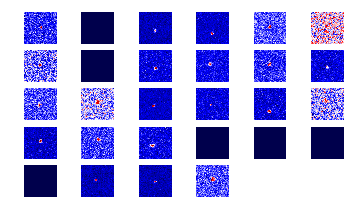

In [86]:
%matplotlib inline
num_cols = 6
num_rows = 6
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx <= len(cells):
            try:
                space, temporal_filters = ft.decompose(stas[plt_idx-1] - np.mean(stas[plt_idx-1]))
            except:
                space = np.zeros((50,50))

            plt.subplot(num_rows, num_cols, plt_idx)
            plt.imshow(space - np.mean(space), cmap='seismic')
            plt.axis('off')

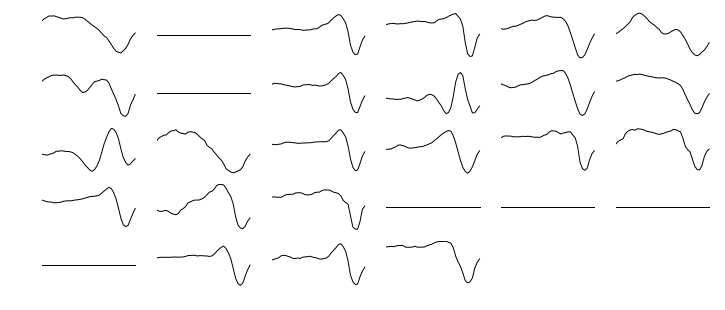

In [87]:
# %matplotlib inline
fig = plt.gcf()
fig.set_size_inches((12,6))
num_cols = 6
num_rows = 6
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx <= len(cells):
            try:
                space, temporal_filters = ft.decompose(stas[plt_idx-1] - np.mean(stas[plt_idx-1]))
            except:
                temporal_filters = np.zeros((filter_length,))

            plt.subplot(num_rows, num_cols, plt_idx)
            plt.plot(temporal_filters, 'k')
            plt.axis('off')
# mpld3.display()

#### save STAs

In [90]:
from deepretina.visualizations import visualize_sta
from matplotlib import gridspec

In [92]:
data_dir = '~/experiments/data/'
expt = '16-05-31'

for c in range(len(cells)):
    try:
        spatial_profile, temporal_filter = ft.decompose(stas[c] - np.mean(stas[c]))
    except:
        space = np.zeros((50,50))
#     plt.imshow(spatial_filter - np.mean(spatial_filter), cmap='seismic')
#     plt_filename = 'sta_cell_%d.png' %(c)
#     plt.savefig(plt_filename)
#     plt.close()

    fig = plt.figure(figsize=(6,10))
    time = np.linspace(0.0, filter_length*10.0, filter_length)
    #fig, ax = pyviz.plotsta(np.linspace(0.0,filter_length*10.0, filter_length), sta, fig=fig)

    # build the figure
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    # plot spatial profile
    ax = fig.add_subplot(gs[0])
    spatial_profile -= np.mean(spatial_profile)
    maxval = np.max(np.abs(spatial_profile))
    img = ax.imshow(spatial_profile, cmap='seismic_r', interpolation='nearest',
            aspect='equal', vmin=-maxval, vmax=maxval)
    ax.set_xticks([])
    ax.set_yticks([])

    # plot temporal profile
    ax = fig.add_subplot(gs[1])
    ax.plot(time, temporal_filter, linestyle='-', linewidth=2, color='LightCoral')
    ax.set_xlim(time[0], time[-1])
    plt.xlabel('Time (ms)', fontsize=20)


    plt.savefig('cell%02i.jpg' %(c+1))
    plt.close()

# Rasters during natural movies

In [343]:
import brewer2mpl

In [352]:
len(repeats)

112

(0, 5)

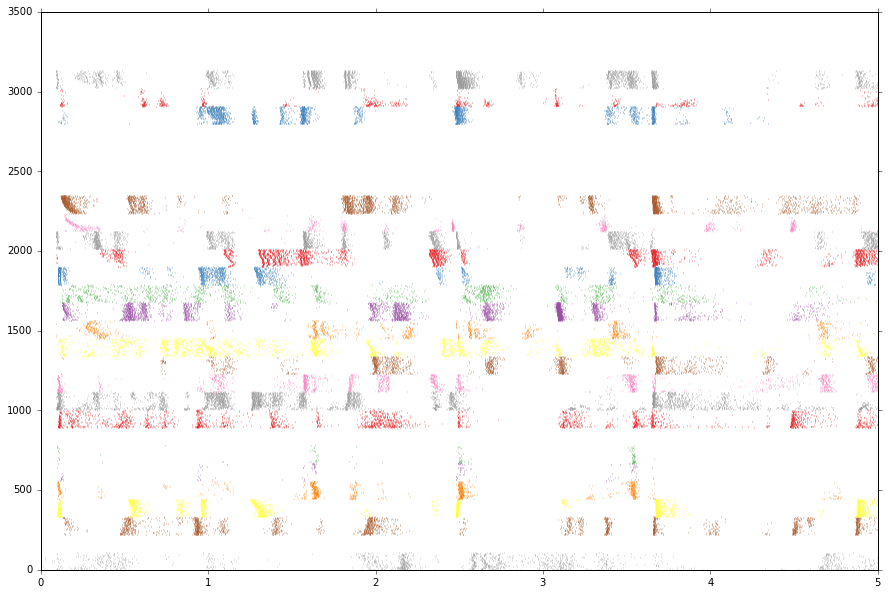

In [359]:
fig = plt.gcf()
fig.set_size_inches((15,10))

ax = plt.gca()
bmap = brewer2mpl.get_map('Set1', 'Qualitative', 9, reverse=True)
colors = bmap.mpl_colors

# structured stimuli
num_repeats = 112
for c in range(len(cells)):
    repeats = []
    for t,stim_type in enumerate(stimulus_seq):
        if stim_type == 'naturalscene_repeat':
            repeats.append(expt_spikes[t][c])

    all_spikes, all_labels = spikes_to_array(repeats)
    all_labels += num_repeats * c
    
    # plot raster for this particular cell
    which_color = c % 9
    ax.plot(all_spikes, all_labels, '|', markersize=1, color=colors[which_color])

plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
# adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xlim([0, 5])

# Save h5 files

In [41]:
import h5py
from pyret.spiketools import binspikes

#### expts to each stim type

In [360]:
whitenoise_test_expts = [i for i,stim_type in enumerate(stimulus_seq) if stim_type == 'whitenoise']
naturalscene_train_expts = [i for i,stim_type in enumerate(stimulus_seq) if stim_type == 'naturalscene_single']
naturalscene_test_expts = [i for i,stim_type in enumerate(stimulus_seq) if stim_type == 'naturalscene_repeat']
print('# whitenoise = %i, # ns repeats = %i, # ns single trial = %i' %(len(whitenoise_test_expts),
                                                                      len(naturalscene_test_expts),
                                                                      len(naturalscene_train_expts)))

# whitenoise = 2, # ns repeats = 112, # ns single trial = 14


#### whitenoise

In [44]:
h = h5py.File('/Users/lmcintosh/experiments/data/16-05-31/whitenoise.h5', 'w')

##### spikes #####
ncells = len(cells)
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

##### train #####
train_stimuli = []
train_times = []
train_response_binned = []
train_response_5ms = []
train_response_10ms = []
train_response_20ms = []
last_time = 0.0
for idx in whitenoise_train_expts:
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        
    train_response_binned.append(np.vstack(binned_spikes))
    train_response_5ms.append(np.vstack(response_5ms))
    train_response_10ms.append(np.vstack(response_10ms))
    train_response_20ms.append(np.vstack(response_20ms))
    train_stimuli.append(stimulus_upsample[:-1])
    train_times.append(time_upsample[:-1] + last_time)
    last_time += time_upsample[-1]
# create datasets
h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
h.create_dataset('train/time', data=np.hstack(train_times))
h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

##### test #####
test_stimuli = []
test_times = []
test_response_binned = []
test_response_5ms = []
test_response_10ms = []
test_response_20ms = []
test_repeats = []
for repeat, idx in enumerate(whitenoise_test_expts):
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        
        if repeat == 0:
            test_repeats.append([r10ms])
        else:
            test_repeats[c].append(r10ms)
    test_response_binned.append(np.vstack(binned_spikes))
    test_response_5ms.append(np.vstack(response_5ms))
    test_response_10ms.append(np.vstack(response_10ms))
    test_response_20ms.append(np.vstack(response_20ms))
# create datasets
h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
h.create_dataset('test/time', data=time_upsample[:-1])
h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
for c in range(len(cells)):
    dataset_name = 'test/repeats/cell%02d' %(c+1)
    h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

h.close()

<HDF5 dataset "firing_rate_5ms": shape (14, 179970), type "<f8">

#### naturalscene

In [364]:
from pyret.spiketools import binspikes

In [365]:
with h5py.File(stim_dir + stimulus_filename) as f:
    with h5py.File('/Users/lmcintosh/experiments/data/16-05-31/naturalscene.h5', 'w') as h:

        ##### spikes #####
        ncells = len(cells)
        for idx in range(ncells):
            h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

        ##### train #####
        train_stimuli = []
        train_times = []
        train_response_binned = []
        train_response_5ms = []
        train_response_10ms = []
        train_response_20ms = []
        last_time = 0.0
        for idx in naturalscene_train_expts:
            expt_name = 'expt%d' %(idx+1)
            stim = f[expt_name + '/stim']
        #     time = f[expt_name + '/timestamps']
            time = np.arange(0, stim.shape[0])/25.00940617
            stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 4, time)
            binned_spikes = []
            response_5ms = []
            response_10ms = []
            response_20ms = []
            for c in range(len(cells)):
                bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
                binned_spikes.append(bspk)
                r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
                r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
                r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
                response_5ms.append(r5ms)
                response_10ms.append(r10ms)
                response_20ms.append(r20ms)
            train_response_binned.append(np.vstack(binned_spikes))
            train_response_5ms.append(np.vstack(response_5ms))
            train_response_10ms.append(np.vstack(response_10ms))
            train_response_20ms.append(np.vstack(response_20ms))
            train_stimuli.append(stimulus_upsample[:-1])
            train_times.append(time_upsample[:-1] + last_time)
            last_time += time_upsample[-1]
        # create datasets
        h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
        h.create_dataset('train/time', data=np.hstack(train_times))
        h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
        h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
        h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
        h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

        ##### test #####
        test_stimuli = []
        test_times = []
        test_response_binned = []
        test_response_5ms = []
        test_response_10ms = []
        test_response_20ms = []
        test_repeats = []
        for repeat, idx in enumerate(naturalscene_test_expts):
            expt_name = 'expt%d' %(idx+1)
            stim = f[expt_name + '/stim']
        #     time = f[expt_name + '/timestamps']
            time = np.arange(0, stim.shape[0])/25.00940617
            stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 4, time)
            binned_spikes = []
            response_5ms = []
            response_10ms = []
            response_20ms = []
            for c in range(len(cells)):
                bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
                binned_spikes.append(bspk)
                r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
                r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
                r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
                response_5ms.append(r5ms)
                response_10ms.append(r10ms)
                response_20ms.append(r20ms)
                if repeat == 0:
                    test_repeats.append([r10ms])
                else:
                    test_repeats[c].append(r10ms)
            test_response_binned.append(np.vstack(binned_spikes))
            test_response_5ms.append(np.vstack(response_5ms))
            test_response_10ms.append(np.vstack(response_10ms))
            test_response_20ms.append(np.vstack(response_20ms))
        # create datasets
        h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
        h.create_dataset('test/time', data=time_upsample[:-1])
        h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
        h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
        h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
        h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
        for c in range(len(cells)):
            dataset_name = 'test/repeats/cell%02d' %(c+1)
            h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

        h.close()

#### structured

In [47]:
h = h5py.File('/Users/lmcintosh/experiments/data/16-01-08/structured.h5', 'w')

##### spikes #####
ncells = len(cells)
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

##### train #####
train_stimuli = []
train_times = []
train_response_binned = []
train_response_5ms = []
train_response_10ms = []
train_response_20ms = []
last_time = 0.0
for idx in structured_train_expts:
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
    train_response_binned.append(np.vstack(binned_spikes))
    train_response_5ms.append(np.vstack(response_5ms))
    train_response_10ms.append(np.vstack(response_10ms))
    train_response_20ms.append(np.vstack(response_20ms))
    train_stimuli.append(stimulus_upsample[:-1])
    train_times.append(time_upsample[:-1] + last_time)
    last_time += time_upsample[-1]
# create datasets
h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
h.create_dataset('train/time', data=np.hstack(train_times))
h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

##### test #####
test_stimuli = []
test_times = []
test_response_binned = []
test_response_5ms = []
test_response_10ms = []
test_response_20ms = []
test_repeats = []
for repeat, idx in enumerate(structured_test_expts):
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        if repeat == 0:
            test_repeats.append([r10ms])
        else:
            test_repeats[c].append(r10ms)
    test_response_binned.append(np.vstack(binned_spikes))
    test_response_5ms.append(np.vstack(response_5ms))
    test_response_10ms.append(np.vstack(response_10ms))
    test_response_20ms.append(np.vstack(response_20ms))
# create datasets
h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
h.create_dataset('test/time', data=time_upsample[:-1])
h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
for c in range(len(cells)):
    dataset_name = 'test/repeats/cell%02d' %(c+1)
    h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

h.close()

#### naturalmovie

In [48]:
h = h5py.File('/Users/lmcintosh/experiments/data/16-01-08/naturalmovie.h5', 'w')

##### spikes #####
ncells = len(cells)
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

##### train #####
train_stimuli = []
train_times = []
train_response_binned = []
train_response_5ms = []
train_response_10ms = []
train_response_20ms = []
last_time = 0.0
for idx in naturalmovie_train_expts:
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
    train_response_binned.append(np.vstack(binned_spikes))
    train_response_5ms.append(np.vstack(response_5ms))
    train_response_10ms.append(np.vstack(response_10ms))
    train_response_20ms.append(np.vstack(response_20ms))
    train_stimuli.append(stimulus_upsample[:-1])
    train_times.append(time_upsample[:-1] + last_time)
    last_time += time_upsample[-1]
# create datasets
h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
h.create_dataset('train/time', data=np.hstack(train_times))
h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

##### test #####
test_stimuli = []
test_times = []
test_response_binned = []
test_response_5ms = []
test_response_10ms = []
test_response_20ms = []
test_repeats = []
for repeat, idx in enumerate(naturalmovie_test_expts):
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        if repeat == 0:
            test_repeats.append([r10ms])
        else:
            test_repeats[c].append(r10ms)
    test_response_binned.append(np.vstack(binned_spikes))
    test_response_5ms.append(np.vstack(response_5ms))
    test_response_10ms.append(np.vstack(response_10ms))
    test_response_20ms.append(np.vstack(response_20ms))
# create datasets
h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
h.create_dataset('test/time', data=time_upsample[:-1])
h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
for c in range(len(cells)):
    dataset_name = 'test/repeats/cell%02d' %(c+1)
    h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

h.close()

# After training models on this experiment, it seems like train and test data are on different scales

In [49]:
f = h5py.File('/Users/lmcintosh/experiments/data/16-01-08/whitenoise.h5', 'r')

In [50]:
list(f)

[u'spikes', u'test', u'train']

In [51]:
list(f['test'])

[u'repeats', u'response', u'stimulus', u'time']

In [52]:
list(f['train'])

[u'response', u'stimulus', u'time']

In [53]:
list(f['test/response'])

[u'binned', u'firing_rate_10ms', u'firing_rate_20ms', u'firing_rate_5ms']

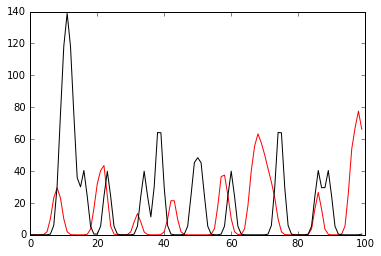

In [54]:
test_segment = np.array(f['test/response/firing_rate_10ms'])
train_segment = np.array(f['train/response/firing_rate_10ms'])

plt.plot(test_segment[0,:100], 'r')
plt.plot(train_segment[0,:100], 'k')

In [55]:
f.close()

#### and now it's fixed!